# Feature Engineering: Draft 1

1. Data Cleaning / EDA
    1. `AGE`: Creation of 'bins'
    2. `EDUCATION`: Grouping categories `4,5,6,0`
    3. `PAY_n`: Categorical/One-Hot Encoding
    4. `SEX`: Categorical/One-Hot Encoding
    5. `MARRIAGE`: Grouping categories `0` and `3`
2. Oversampling (SMOTE + ENN)
3. Feature Engineering/Creation
    1. Timeseries Clustering
        1. `PAY` -> `PAY_CLUSTER`
        2. `PAY_AMT` -> `PAY_AMT_CLUSTER`
    2. Encoding Domain Expertise
        1. Average repayment status (categorical)
        2. Average bill amount outstanding above/below average payment (categorical)
        3. Average *change* in MoM repayment status
        4. Frequency variables
        5. Outlier Removal
5. Feature Selection
    1. Weight-based
    2. PCA

# Preliminaries

* **Imports**
* **Data Loading**

In [1]:
# general tools
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# use Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# paper style
plt.style.use('seaborn-paper')

# preprocessing
import scipy.cluster.hierarchy as sch

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# data imports

### EDIT FILEPATH IF NECESSARY
root = '.'
data_dir = '/DataFiles/'

# form filepaths
data_path = root + data_dir
train_file = data_path + 'CreditCard_train.csv'
test_file = data_path + 'CreditCard_test.csv'

# load
_df_train = pd.read_csv(train_file, index_col=0, header=1).rename(columns={'PAY_0':'PAY_1', 'default payment next month':'DEFAULT'})
_df_test = pd.read_csv(test_file, index_col=0, header=1).rename(columns={'PAY_0':'PAY_1', 'default payment next month':'DEFAULT'})

# Data Cleaning & EDA


## Data Cleaning

To be cleaned:
* `AGE`: Creation of 'bins'
* `EDUCATION`: Grouping categories `4,5,6,0`
* `PAY_n`: Categorical/One-Hot Encoding
* `SEX`: Categorical/One-Hot Encoding
* `MARRIAGE`: Grouping categories `0` and `3`

In [3]:
# create copy df for handling
df_train = _df_train.copy()
df_test = _df_test.copy()

In [86]:
df_test.shape

(6000, 24)

### Cleaning Vars

#### Age

In [4]:
# inspect
_df_train.AGE.describe()

count    24000.000000
mean        35.380458
std          9.271050
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64

In [5]:
# create bins for 'AGE'
df_train['AGE_BIN'] = pd.cut(df_train.AGE,
                              bins=[20,40,60,100],
                              labels=[1,2,3])

# drop 'AGE'
df_train.drop(['AGE'], axis=1, inplace=True)

# inspect
df_train.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT,AGE_BIN
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,2,2,-1,-1,-2,-2,...,0,0,0,689,0,0,0,0,1,1
2,120000,2,2,2,-1,2,0,0,0,2,...,3455,3261,0,1000,1000,1000,0,2000,1,1
3,90000,2,2,2,0,0,0,0,0,0,...,14948,15549,1518,1500,1000,1000,1000,5000,0,1
4,50000,2,2,1,0,0,0,0,0,0,...,28959,29547,2000,2019,1200,1100,1069,1000,0,1
5,50000,1,2,1,-1,0,-1,0,0,0,...,19146,19131,2000,36681,10000,9000,689,679,0,2


#### Education

In [6]:
# inspect
_df_train.EDUCATION.value_counts()

2    11360
1     8443
3     3850
5      207
4       92
6       37
0       11
Name: EDUCATION, dtype: int64

In [7]:
# Group 4,5,6,0 categories for 'EDUCATION'
ed_map = {1:1, 2:2, 3:3, 4:4, 5:4, 6:4, 0:4}
df_train.EDUCATION = df_train.EDUCATION.map(ed_map)

# inspect
df_train.EDUCATION.value_counts()

2    11360
1     8443
3     3850
4      347
Name: EDUCATION, dtype: int64

#### Marriage

In [8]:
# inspect
_df_train.MARRIAGE.value_counts()

2    12877
1    10813
3      269
0       41
Name: MARRIAGE, dtype: int64

In [9]:
# Group 0, 3 categories for 'MARRIAGE'
marr_map = {0:0, 1:1, 2:2, 3:0}
df_train.MARRIAGE = df_train.MARRIAGE.map(marr_map)

# inspect
df_train.MARRIAGE.value_counts()

2    12877
1    10813
0      310
Name: MARRIAGE, dtype: int64

### Encoding Categoricals

Need to encode:
* `AGE`
* `EDUCATION`
* `SEX`
* `MARRIAGE`

Note that we leave `PAY_n` unencoded because it is semi-continuous (i.e. the increase in the figure corresponds to an increase in months outstanding for payment).

In [10]:
# encoding categoricals
categoricals = ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE_BIN']
for col in categoricals: 
    df_train[col] = df_train[col].astype('category')

# create dummy cols, join, and drop old
cat_df = df_train[categoricals]
cat_df = pd.get_dummies(cat_df)
df_train = df_train.join(cat_df).drop(categoricals, axis=1)

# inspect
df_train.head()

,LIMIT_BAL,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,...,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,AGE_BIN_1,AGE_BIN_2,AGE_BIN_3
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,-1,-1,-2,-2,3913,3102,689,...,0,1,0,0,0,1,0,1,0,0
2,120000,-1,2,0,0,0,2,2682,1725,2682,...,0,1,0,0,0,0,1,1,0,0
3,90000,0,0,0,0,0,0,29239,14027,13559,...,0,1,0,0,0,0,1,1,0,0
4,50000,0,0,0,0,0,0,46990,48233,49291,...,0,1,0,0,0,1,0,1,0,0
5,50000,-1,0,-1,0,0,0,8617,5670,35835,...,0,1,0,0,0,1,0,0,1,0


### Outlier Removal

* `LIMIT_BAL` only

## EDA

### Distributions

In [11]:
# set up graphic
def plot_hist(df, features, num_r, num_c):
    
    # set up graphics
    fig, axs = plt.subplots(6, 2, figsize=(16, 24), sharex=False, sharey=False)
    colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:pink', 'tab:olive', 'tab:orange']

    # plot grid
    for i in range(num_r):
        feature = features[i]
        for j in range(num_c):
            if j == 1:
                scaler = StandardScaler()
                x = scaler.fit_transform(df[feature].values.reshape(-1,1)) # standardize second row
                title = feature + ' (Standardized)'
            else: 
                x = df[feature]
                title = feature + ' (Unstandardized)'
            ax = sns.distplot(x, hist=True, kde=False, ax=axs[i, j])
            ax.set(xlabel=None, ylabel="Counts")
            ax.set_title(title, fontweight='bold')

    # display
    plt.subplots_adjust(hspace=0.4)
    plt.suptitle('THIS IS THE TITLE', y=0.90, fontsize='x-large', fontweight='bold')

/Users/Jurren/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/Jurren/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/Jurren/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

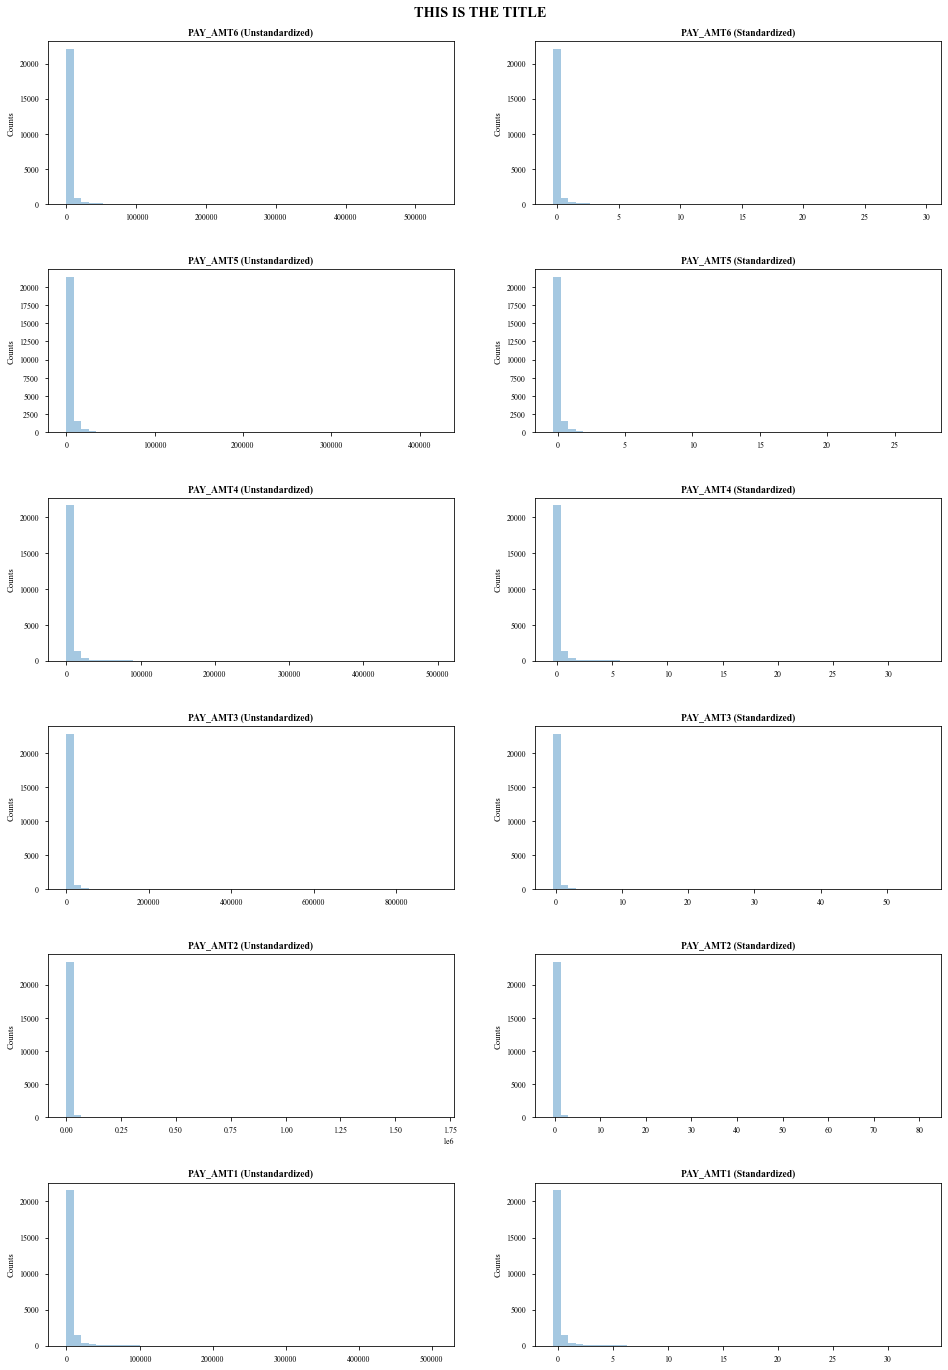

In [12]:
# distributions for 'PAY_AMT'
pay_amt_features = ['PAY_AMT6', 'PAY_AMT5', 'PAY_AMT4', 'PAY_AMT3', 'PAY_AMT2', 'PAY_AMT1']
plot_hist(df_train, pay_amt_features, 6, 2)

/Users/Jurren/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/Jurren/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/Jurren/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

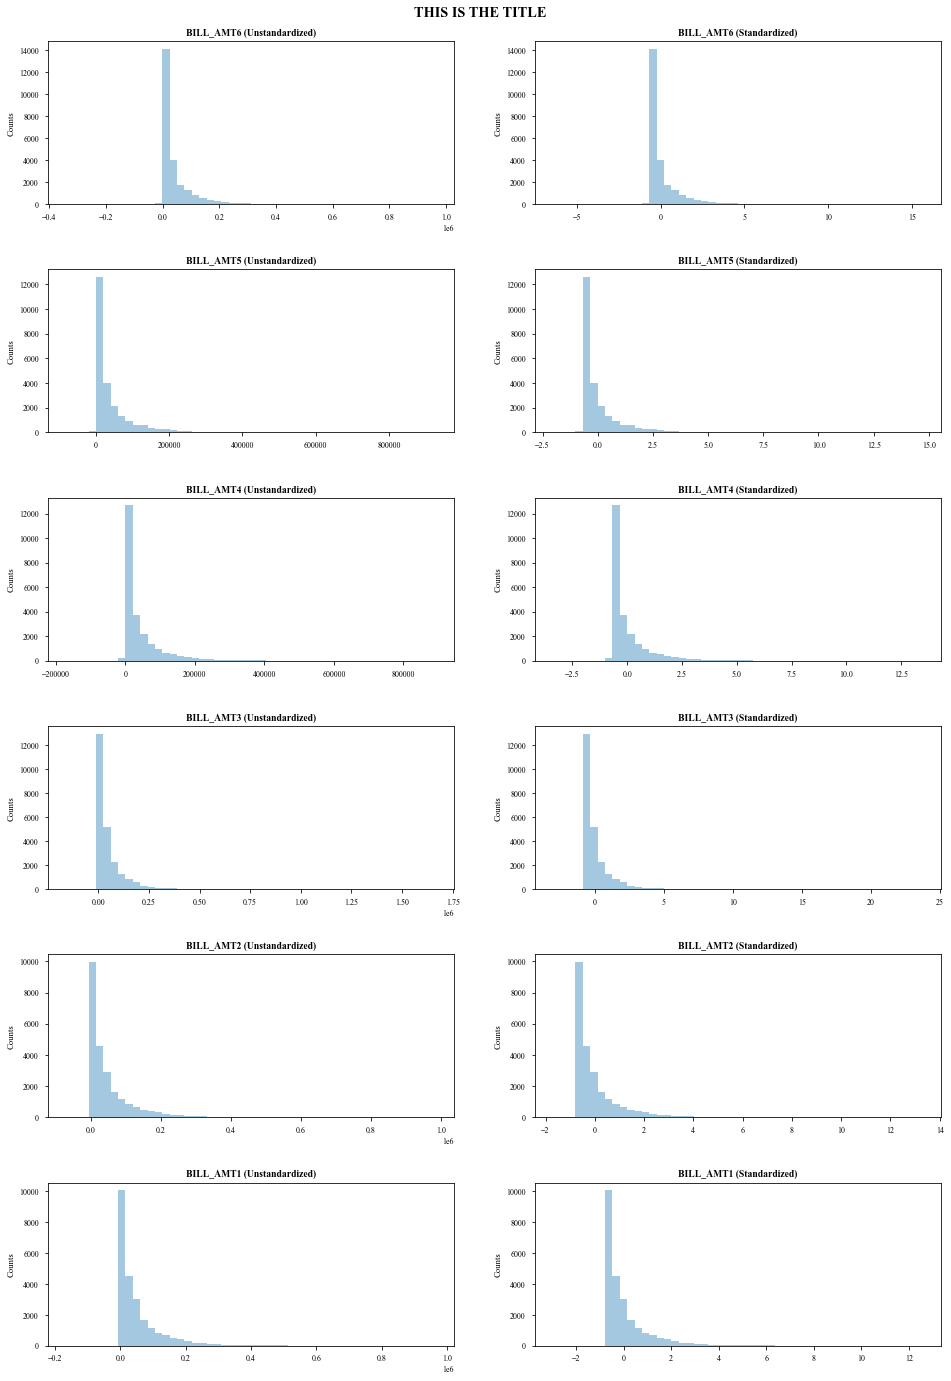

In [13]:
# distributions for 'BILL_AMT'
pay_amt_features = ['BILL_AMT6', 'BILL_AMT5', 'BILL_AMT4', 'BILL_AMT3', 'BILL_AMT2', 'BILL_AMT1']
plot_hist(df_train, pay_amt_features, 6, 2)

### Class Imbalance

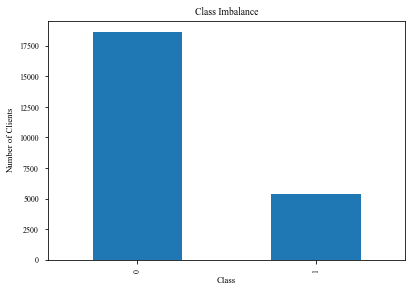

In [14]:
# plot class imbalance
pd.value_counts(df_train['DEFAULT']).plot.bar()
plt.title('Class Imbalance')
plt.xlabel("Class")
plt.ylabel("Number of Clients")
plt.show()

### Under- and Over-sampling: SMOTE + Tomek

In [15]:
# define features
cols = df_train.columns.values
to_drop = ['DEFAULT']
features = np.setdiff1d(cols, to_drop)

# inspect
features

array(['AGE_BIN_1', 'AGE_BIN_2', 'AGE_BIN_3', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'EDUCATION_1',
       'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4', 'LIMIT_BAL',
       'MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX_1', 'SEX_2'],
      dtype=object)

In [16]:
# assign df features
df_features = df_train[features]

In [17]:
# set data
X = df_features
y = df_train['DEFAULT']

# simple oversampling with SMOTE
smote = SMOTE(random_state=42)
df_train_smote, df_train_smote['DEFAULT'] = smote.fit_resample(X, y)

# hybrid resampling SMOTETomek
smt = SMOTETomek(random_state=42)
df_train_smt, df_train_smt['DEFAULT'] = smt.fit_resample(X, y)

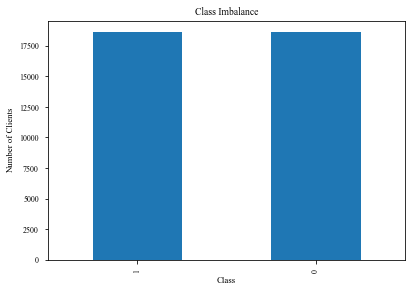

In [18]:
# plot results with SMOTE
pd.value_counts(df_train_smote['DEFAULT']).plot.bar()
plt.title('Class Imbalance')
plt.xlabel("Class")
plt.ylabel("Number of Clients")
plt.show()

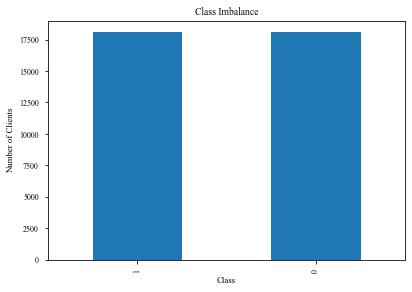

In [19]:
# plot results with SMOTETomek
pd.value_counts(df_train_smt['DEFAULT']).plot.bar()
plt.title('Class Imbalance')
plt.xlabel("Class")
plt.ylabel("Number of Clients")
plt.show()

In [20]:
# we select the SMOTE-Tomek data to move forward
df_train = df_train_smt.copy()
y_train = df_train_smt['DEFAULT']

### Correlations

First, we try to visualize the correlations of the data, and include a weighting of the correlations between features and the target variable.

In [21]:
# compute feature correlation matrix
df_feature_corr = df_features.corr()
corr_matrix = np.asmatrix(df_feature_corr)

# compute feature correlations with target
target_corr = df_train.corr().loc['DEFAULT', df_train.corr().columns.difference(['DEFAULT'])].to_numpy()

In [22]:
# Creates graph using the data from the correlation matrix
G = nx.from_numpy_matrix(corr_matrix)

# relabels nodes to match features
G = nx.relabel_nodes(G, lambda x: features[x])

In [23]:
def create_corr_network(G, corr_dir, min_corr, sizes):
    '''
    Plots a circular correlation network between all features. The weight
    of the edges corresponds to the correlation between two features.
    The size of the nodes corresponds to another desired arbitrary indicator.
    
    Args:
        G (NetworkX Graph Object): Graph.
        corr_dir (String): Direction of the correlations to examine
                          (positive or negative).
        min_corr (Float): Minimum correlation for edge to be displayed.
        sizes (List of Floats): Size of each node in the network. 
        
    Returns:
        None
    '''
    
    # creates a copy of the graph
    H = G.copy()
    
    # checks all edges and removes some based on corr_dir, and min_corr
    for feat_1, feat_2, weight in G.edges(data=True):
        if corr_dir == 'positive':
            if weight['weight'] < 0 or abs(weight['weight']) < min_corr:
                H.remove_edge(feat_1, feat_2)
        else:
            if weight['weight'] >= 0 or abs(weight['weight']) < min_corr:
                H.remove_edge(feat_1, feat_2)
                
    # create list for the edges and for the weights
    edges, weights = zip(*nx.get_edge_attributes(H,'weight').items())
    
    # increase weight values to make vals more distinct 
    weights = tuple([(1 + abs(x))**2 for x in weights])
    
    # calculates degree of each node
    nodelist, node_sizes = zip(*nx.degree(H))
    
    # positions
    positions = nx.circular_layout(H)
    
    # fig size
    plt.figure(figsize=(15,15))
    
    # draws nodes
    nx.draw_networkx_nodes(H, 
                           positions, 
                           node_color='#DA70D6',
                           nodelist=nodelist,
                           node_size=[abs(x)*5000 for x in sizes], 
                           alpha=0.8)
    
    # styling for labels
    nx.draw_networkx_labels(H, 
                            positions, 
                            font_size=8,
                            font_family='sans-serif')
    
    # color setting
    if corr_dir == 'positive':
        main_color = plt.cm.GnBu
    else:
        main_color = plt.cm.PuRd
    
    # draws the edges
    nx.draw_networkx_edges(H, 
                           positions, 
                           edgelist=edges, 
                           style='solid',
                           width=weights,
                           edge_color=weights,
                           edge_cmap=main_color,
                           edge_vmin=min(weights),
                           edge_vmax=max(weights))
    
    # displays the graph without axis
    plt.axis('off')

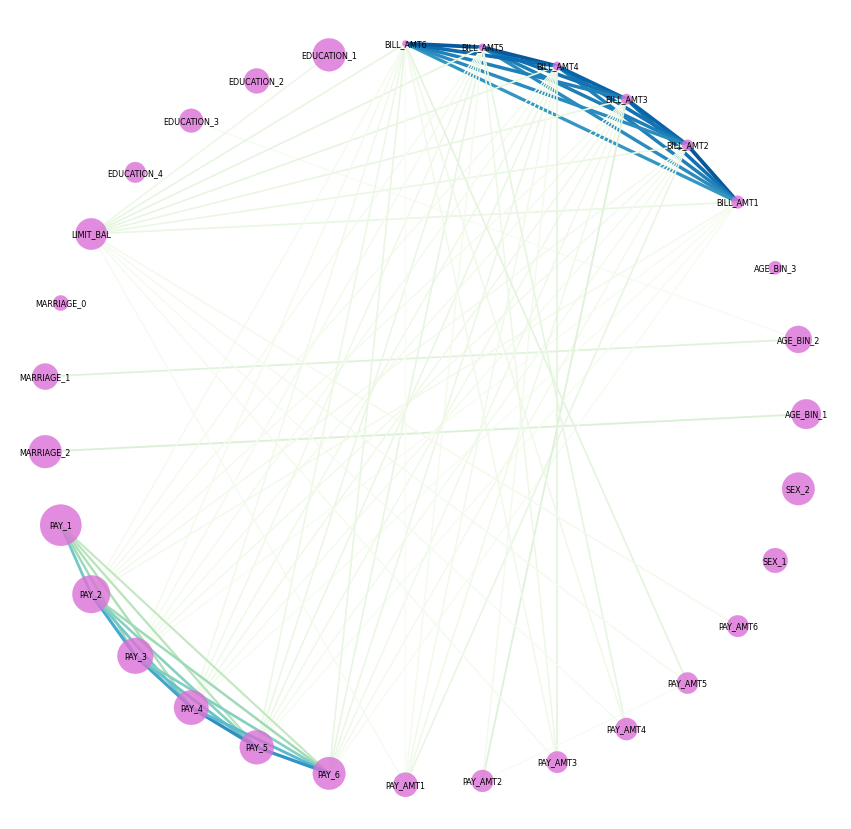

In [24]:
# Plot positive corr network for corrs. > 0.2, 
# assigning each node a size according to its correlation with the
# target variable
create_corr_network(G, 'positive', 0.2, target_corr)

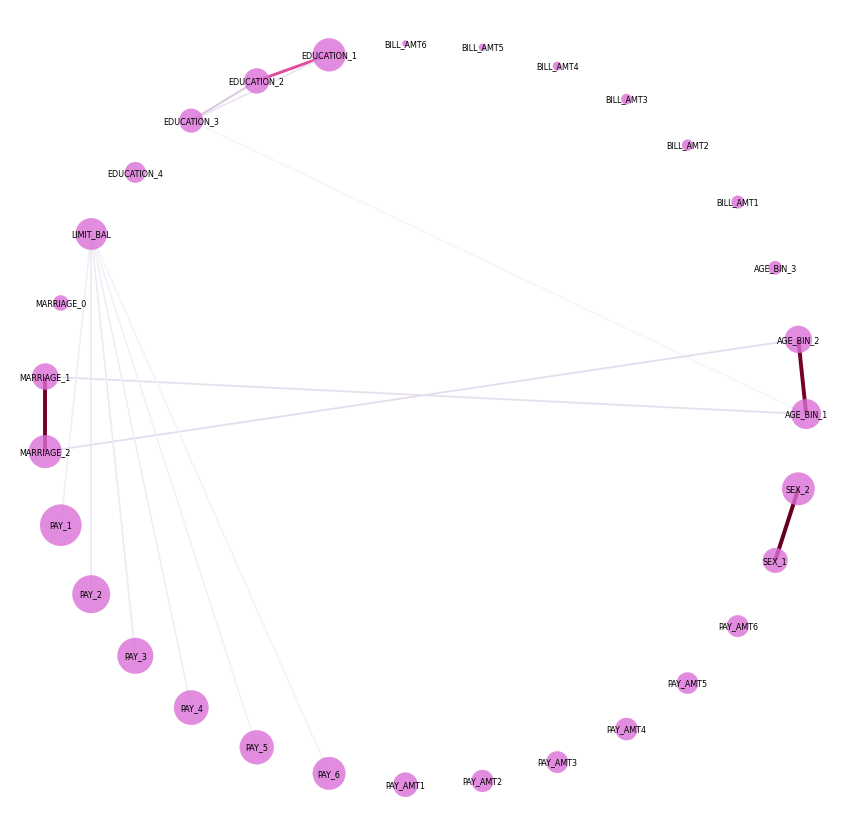

In [25]:
# Plot negative corr network for corrs. > 0.2, 
# assigning each node a size according to its correlation with the
# target variable
create_corr_network(G, 'negative', 0.2, target_corr)

                      NOT_DEFAULT  DEFAULT  TOTAL  NON_DEFAULT_%  DEFAULT_%
PAY_1                                                                      
No Consumption               1747      476   2223           0.79       0.21
Paid in Full                 3700     2149   5849           0.63       0.37
Use Revolving Credit         9976     6891  16867           0.59       0.41
Delay 1 mth                  1918     4535   6453           0.30       0.70
Delay 2 mths                  666     3601   4267           0.16       0.84
Delay 3 mths                   58      331    389           0.15       0.85
Delay 4 mths                   22       73     95           0.23       0.77
Delay 5 mths                    8       18     26           0.31       0.69
Delay 6 mths                    4       10     14           0.29       0.71
Delay 7 mths                    1       13     14           0.07       0.93
Delay 8 mths                    6        9     15           0.40       0.60


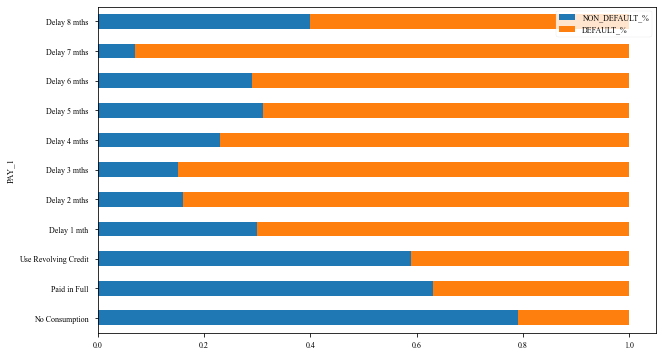

In [26]:
# Examine % distribution of PAY_1 among defaults and non-defaults

default0 = df_train.groupby(df_train['PAY_1'][df_train['DEFAULT'] == 0]).size().reset_index(name='NOT_DEFAULT')
default1 = df_train.groupby(df_train['PAY_1'][df_train['DEFAULT'] == 1]).size().reset_index(name='DEFAULT')
total = df_train.groupby('PAY_1').size().reset_index(name='TOTAL')

pay1_classes = default0.join(default1['DEFAULT']).join(total['TOTAL'])
pay1_classes['PAY_1'] = ['No Consumption','Paid in Full','Use Revolving Credit','Delay 1 mth','Delay 2 mths'
                     ,'Delay 3 mths','Delay 4 mths','Delay 5 mths','Delay 6 mths','Delay 7 mths','Delay 8 mths']

pay1_classes['NON_DEFAULT_%'] = round((pay1_classes['NOT_DEFAULT']/pay1_classes['TOTAL']),2)
pay1_classes['DEFAULT_%'] = round((pay1_classes['DEFAULT']/pay1_classes['TOTAL']),2)

pay1_classes.set_index('PAY_1', inplace=True)

print(pay1_classes)

pay1_classes[['NON_DEFAULT_%', 'DEFAULT_%']].plot.barh(stacked=True, figsize=(10,6))

# Feature Engineering

1. Timeseries Analysis for:
    1. PAY
    2. PAY_AMT
    3. 

## Timeseries Analysis: K-Means


### PAY

In [27]:
# select data
pay_features = ['PAY_6', 'PAY_5', 'PAY_4', 'PAY_3', 'PAY_2', 'PAY_1']
df_pay = df_train[pay_features]

# inspect
df_pay.head()

,PAY_6,PAY_5,PAY_4,PAY_3,PAY_2,PAY_1
0,-2,-2,-1,-1,2,2
1,2,0,0,0,2,-1
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,-1,0,-1


In [28]:
# helper: visualize cluster results
def plot_average(centroids, title, labels):
    plt.title(title)
    plt.xticks(range(len(labels)), labels)
    for c in centroids:
        plt.plot(c)

In [29]:
# try different cluster sizes
n_clusters = range(3, 7)
_kmeans_pay = {}

for n in n_clusters:
    _kmeans_pay[n] = KMeans(n_clusters=n, random_state=42).fit(df_pay)

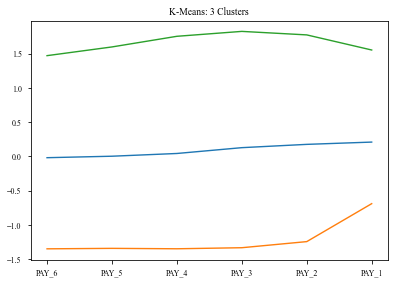

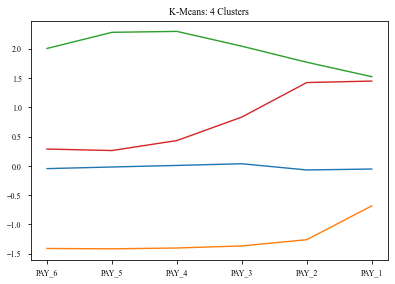

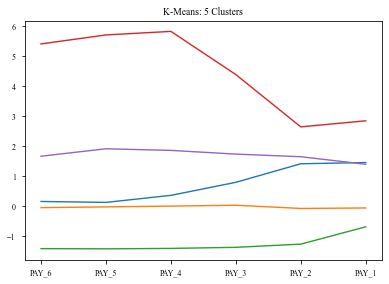

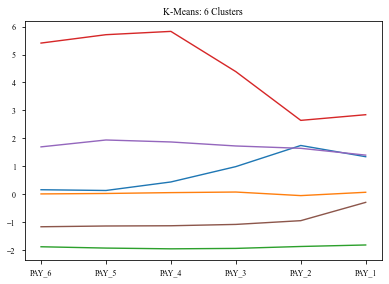

In [30]:
for key, item in _kmeans_pay.items():
    plot_average(item.cluster_centers_, 'K-Means: {} Clusters'.format(key), pay_features)
    plt.show()

In [31]:
def plot_avg_sil(data, kmeans_dict, n_clusters, var):
    
    # compute 
    avg_sil = {}
    for i, n in enumerate(n_clusters):
        data_sil = silhouette_score(data, kmeans_dict[n].labels_)
        avg_sil[n] = data_sil / data.shape[0]
    
    # collect vals
    avg_sil_val = [v for v in avg_sil.values()]

    # plot
    plt.plot(n_clusters, avg_sil_val)
    plt.xticks(n_clusters)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Avg. Silhouette Score')
    plt.title('Avg. Silhouette Score for Different K-Means Clusters:\n{}'.format(var), weight='bold')
    plt.show()

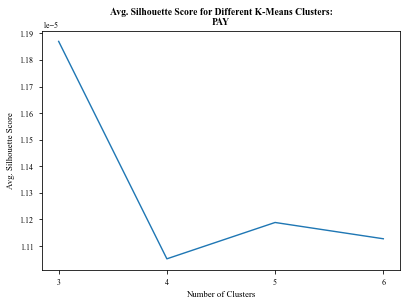

In [32]:
# analyze average silhouette
plot_avg_sil(df_pay, _kmeans_pay, n_clusters, 'PAY')

From the above graph, we conclude that 3 clusters is the ideal number.

In [33]:
# encode clusters in data
pay_clusters = _kmeans_pay[3].labels_
df_pay_clusters = pd.DataFrame({'PAY_CLUSTER':pay_clusters})
df_pay_clusters['PAY_CLUSTER'] = df_pay_clusters['PAY_CLUSTER'].astype('category')

# one-hot encode
cat_df_pc = pd.get_dummies(df_pay_clusters)

# join with df_train
df_train = df_train.join(cat_df_pc)

# inspect
df_train.head()

,AGE_BIN_1,AGE_BIN_2,AGE_BIN_3,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,EDUCATION_1,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,DEFAULT,PAY_CLUSTER_0,PAY_CLUSTER_1,PAY_CLUSTER_2
0,1,0,0,3913,3102,689,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
1,1,0,0,2682,1725,2682,3272,3455,3261,0,...,1000,1000,0,2000,0,1,1,1,0,0
2,1,0,0,29239,14027,13559,14331,14948,15549,0,...,1000,1000,1000,5000,0,1,0,1,0,0
3,1,0,0,46990,48233,49291,28314,28959,29547,0,...,1200,1100,1069,1000,0,1,0,1,0,0
4,0,1,0,8617,5670,35835,20940,19146,19131,0,...,10000,9000,689,679,1,0,0,1,0,0


### PAY_AMT

In [34]:
# select data
pay_amt_features = ['PAY_AMT6', 'PAY_AMT5', 'PAY_AMT4', 'PAY_AMT3', 'PAY_AMT2', 'PAY_AMT1']
df_pay_amt = df_train[pay_amt_features]

# inspect
df_pay_amt.head()

,PAY_AMT6,PAY_AMT5,PAY_AMT4,PAY_AMT3,PAY_AMT2,PAY_AMT1
0,0,0,0,0,689,0
1,2000,0,1000,1000,1000,0
2,5000,1000,1000,1000,1500,1518
3,1000,1069,1100,1200,2019,2000
4,679,689,9000,10000,36681,2000


In [35]:
# try different cluster sizes
n_clusters = range(3, 7)
_kmeans_pay_amt = {}

for n in n_clusters:
    _kmeans_pay_amt[n] = KMeans(n_clusters=n, random_state=42).fit(df_pay_amt)

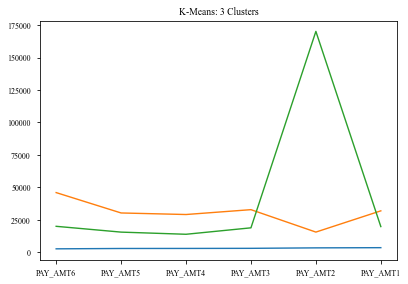

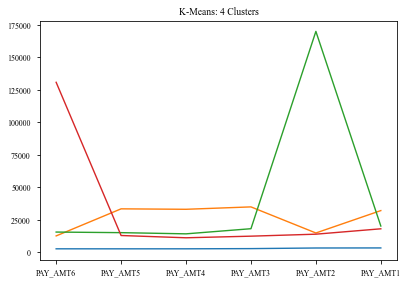

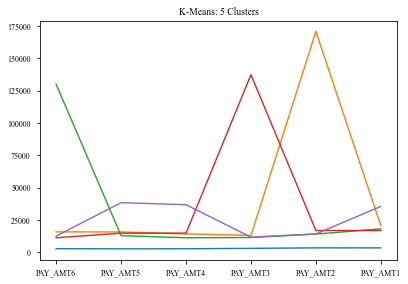

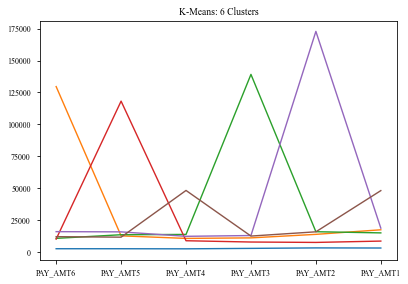

In [36]:
# visualize centroid results
for key, item in _kmeans_pay_amt.items():
    plot_average(item.cluster_centers_, 'K-Means: {} Clusters'.format(key), pay_amt_features)
    plt.show()

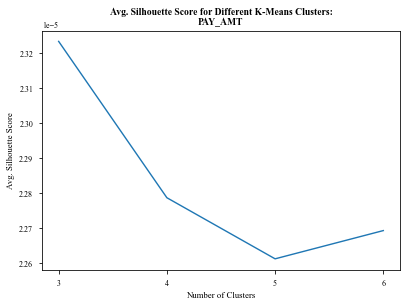

In [37]:
# analyze average silhouette
plot_avg_sil(df_pay_amt, _kmeans_pay_amt, n_clusters, 'PAY_AMT')

From the graph, it becomes clear that 8 clusters is the right number.

In [38]:
# encode clusters in data
pay_amt_clusters = _kmeans_pay_amt[3].labels_
df_pay_amt_clusters = pd.DataFrame({'PAY_AMT_CLUSTER':pay_amt_clusters})
df_pay_amt_clusters['PAY_AMT_CLUSTER'] = df_pay_amt_clusters['PAY_AMT_CLUSTER'].astype('category')

# one-hot encode
cat_df_pamtc = pd.get_dummies(df_pay_amt_clusters)

# join with df_train
df_train = df_train.join(cat_df_pamtc)

# inspect
df_train.head()

,AGE_BIN_1,AGE_BIN_2,AGE_BIN_3,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,EDUCATION_1,...,PAY_AMT6,SEX_1,SEX_2,DEFAULT,PAY_CLUSTER_0,PAY_CLUSTER_1,PAY_CLUSTER_2,PAY_AMT_CLUSTER_0,PAY_AMT_CLUSTER_1,PAY_AMT_CLUSTER_2
0,1,0,0,3913,3102,689,0,0,0,0,...,0,0,1,1,1,0,0,1,0,0
1,1,0,0,2682,1725,2682,3272,3455,3261,0,...,2000,0,1,1,1,0,0,1,0,0
2,1,0,0,29239,14027,13559,14331,14948,15549,0,...,5000,0,1,0,1,0,0,1,0,0
3,1,0,0,46990,48233,49291,28314,28959,29547,0,...,1000,0,1,0,1,0,0,1,0,0
4,0,1,0,8617,5670,35835,20940,19146,19131,0,...,679,1,0,0,1,0,0,1,0,0


### Domain Expertise Encoding

## Additional Features

Five features to be tried out:

1. Average repayment status (categorical)

2. Average bill amount outstanding above/below average payment (categorical)

3. Average *change* in MoM repayment status

4. Frequency variables

### Average Repayment Status

In [39]:
# @helper method
def get_avg(df, features):
    data = df.copy()
    total = 0
    for feat in features: total += data[feat]
    return total / len(features)  

In [40]:
# list of all pay features
pay_features = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# compute
X_train_aug = df_train.copy()
X_train_aug['AVG_PAY'] = get_avg(df_train, pay_features)

### Average Bill Amount Outstanding vs Average Payment ('Sufficiency')

In [41]:
# lists of pay amount and bill amount features
pay_amt_features = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
bill_features = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

# Compute
X_train_aug['AVG_BILL_AMT'] = get_avg(X_train_aug, bill_features)
X_train_aug['AVG_PAY_AMT'] = get_avg(X_train_aug, pay_amt_features)

X_train_aug['SUFF'] = np.where(X_train_aug['AVG_BILL_AMT'] <= X_train_aug['AVG_PAY_AMT'], 1, 0)

### Average Change in MoM Repayment Status

In [42]:
# create dummies
dummy_train = X_train_aug.copy()

# compute deltas and mean delta
dummy_train['DELTA_12'] = dummy_train['PAY_2'] - dummy_train['PAY_1']
dummy_train['DELTA_23'] = dummy_train['PAY_3'] - dummy_train['PAY_2']
dummy_train['DELTA_34'] = dummy_train['PAY_4'] - dummy_train['PAY_3']
dummy_train['DELTA_45'] = dummy_train['PAY_5'] - dummy_train['PAY_4']
dummy_train['DELTA_56'] = dummy_train['PAY_6'] - dummy_train['PAY_5']
deltas = ['DELTA_12', 'DELTA_23', 'DELTA_34', 'DELTA_45', 'DELTA_56']
dummy_train['AVG_DELTA'] = dummy_train[deltas].mean(axis=1)
    
# create new feature
X_train_aug['AVG_PAY_DELTA'] = dummy_train['AVG_DELTA']

### Frequency Variables

In [43]:
# compute frequency of 3+ months overdue
for pay_feature in pay_features:
    X_train_aug['FREQ_{}'.format(pay_feature)] = np.where((X_train_aug[pay_feature] >= 3),1, 
                                                (np.where(X_train_aug[pay_feature] <3,0,X_train_aug[pay_feature])))

pay_delays = ['FREQ_PAY_1', 'FREQ_PAY_2','FREQ_PAY_3','FREQ_PAY_4','FREQ_PAY_5','FREQ_PAY_6',]
X_train_aug['PAY_DELAY_FREQ'] = X_train_aug[pay_delays].sum(axis=1)

# compute frequency of paying on time (-2;-1;0)
for pay_feature in pay_features:
    X_train_aug['TIMELY_{}'.format(pay_feature)] = np.where((X_train_aug[pay_feature] <= 0),1, 
                                                (np.where(X_train_aug[pay_feature] >0,0,X_train_aug[pay_feature])))

pay_timely = ['TIMELY_PAY_1', 'TIMELY_PAY_2','TIMELY_PAY_3','TIMELY_PAY_4','TIMELY_PAY_5','TIMELY_PAY_6',]
X_train_aug['PAY_TIMELY_FREQ'] = X_train_aug[pay_timely].sum(axis=1)

# drop extra columns
X_train_aug.drop(pay_delays, axis=1, inplace=True)
X_train_aug.drop(pay_timely, axis=1, inplace=True)

In [44]:
# list of onthly repayment features
pay_amounts = ['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']

# compute frequency of having monthly repayments > 0
for pay_amt_feature in pay_amt_features:
    X_train_aug['FREQ_{}'.format(pay_amt_feature)] = np.where((X_train_aug[pay_amt_feature] > 0),1, 
                                                (np.where(X_train_aug[pay_amt_feature] <=0,0,
                                                 X_train_aug[pay_amt_feature])))

repayments = ['FREQ_PAY_AMT1', 'FREQ_PAY_AMT2','FREQ_PAY_AMT3','FREQ_PAY_AMT4','FREQ_PAY_AMT5','FREQ_PAY_AMT6',]
X_train_aug['REPAY_FREQ'] = X_train_aug[repayments].sum(axis=1)

# drop extra columns
X_train_aug.drop(repayments, axis=1, inplace=True)

In [45]:
# print final list of features
print(list(X_train_aug.columns))

# moving back to df_train
df_train = X_train_aug.copy()

['AGE_BIN_1', 'AGE_BIN_2', 'AGE_BIN_3', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4', 'LIMIT_BAL', 'MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX_1', 'SEX_2', 'DEFAULT', 'PAY_CLUSTER_0', 'PAY_CLUSTER_1', 'PAY_CLUSTER_2', 'PAY_AMT_CLUSTER_0', 'PAY_AMT_CLUSTER_1', 'PAY_AMT_CLUSTER_2', 'AVG_PAY', 'AVG_BILL_AMT', 'AVG_PAY_AMT', 'SUFF', 'AVG_PAY_DELTA', 'PAY_DELAY_FREQ', 'PAY_TIMELY_FREQ', 'REPAY_FREQ']


## Feature Selection

In [46]:
# re-define features post-feature engineering
cols = df_train.columns.values
to_drop = ['DEFAULT']
features = np.setdiff1d(cols, to_drop)

# inspect
features

array(['AGE_BIN_1', 'AGE_BIN_2', 'AGE_BIN_3', 'AVG_BILL_AMT', 'AVG_PAY',
       'AVG_PAY_AMT', 'AVG_PAY_DELTA', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'EDUCATION_1',
       'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4', 'LIMIT_BAL',
       'MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'PAY_AMT_CLUSTER_0', 'PAY_AMT_CLUSTER_1', 'PAY_AMT_CLUSTER_2',
       'PAY_CLUSTER_0', 'PAY_CLUSTER_1', 'PAY_CLUSTER_2',
       'PAY_DELAY_FREQ', 'PAY_TIMELY_FREQ', 'REPAY_FREQ', 'SEX_1',
       'SEX_2', 'SUFF'], dtype=object)

### Weight-Based Approach

**Objective**:
* Instead of computing communities based off of the Louvain algorithm, whose maths are beyond the scope of the course, we can compute neighborhoods hierarchically by looking at the correlations between variables. Most clustering algorithms utilize Euclidean distance to determine the proximity of two points. For our case, we can instead use the reciprocal of the correlation as the distance. That way, two features that are very correlated (~ 1.0) will have a 'distance' of ~ 1.0 between them. However, others that are less correlated (~0) will have a much greater 'distance' between them. Thus, we can iteratively group features and create communities in this way. 

* To do so, we will utilize Sci-Kit Learn's Agglomerative Clustering algorithm, which admits precomputed distances as an input. Our precomputed distances will be a matrix with element-wise reciprocals of the correlation matrix. We will then visualize the successive clusters that are formed, and decide a level of hierarchy we wish to use. 

**Game Plan:**

1. Compute reciprocal of corr matrix and make values absolute (because distance must be positive)
2. Create Dendrograms using Scipy to see tree-form of clusters, and identify the optimal number of clusters to use in Sci-Kit Learn's `AgglomerativeClustering` model.
2. Feed the rec. corr matrix into an `agg` clustering model, which is characterized by:
    1. `average` linkage method, given its flexibility with weird datasets.
    2. `precomputed` affinity, since we are providing precomputed distances (in our case, the reciprocal of the corr matrix). 
3. Plot the resulting groups into a community graph that better visualizes the clusters of features.
4. Interpret these clusters.
5. Compute weights based on the summation x target variable correlation method

In [47]:
# select features to compute correlation matrix
df_features = df_train[features]
df_features_corr = df_features.corr()

# convert to numpy matrix
corr_matrix = np.asmatrix(df_features_corr)

# extract correlations with target label, and drop target's correlation
# with itself
target_corr = df_train.corr().loc['DEFAULT', :].to_numpy()
target_index = np.where(target_corr == 1.0)
target_corr = np.delete(target_corr, target_index)

# sanity check: assert same num. features as num. correlations
assert len(features) == len(target_corr)

# Creates graph using the data from the correlation matrix
G = nx.from_numpy_matrix(corr_matrix)

# relabels nodes to match features
G = nx.relabel_nodes(G, lambda x: features[x])

# shows the edges with their corresponding weights
G.edges(data=True)

EdgeDataView([('AGE_BIN_1', 'AGE_BIN_1', {'weight': 1.0}), ('AGE_BIN_1', 'AGE_BIN_2', {'weight': -0.6795564000298462}), ('AGE_BIN_1', 'AGE_BIN_3', {'weight': -0.10590312760959729}), ('AGE_BIN_1', 'AVG_BILL_AMT', {'weight': -0.021190732533674973}), ('AGE_BIN_1', 'AVG_PAY', {'weight': -0.040532173870374354}), ('AGE_BIN_1', 'AVG_PAY_AMT', {'weight': 0.013108693053422254}), ('AGE_BIN_1', 'AVG_PAY_DELTA', {'weight': 0.01270646553795781}), ('AGE_BIN_1', 'BILL_AMT1', {'weight': -0.021414740784865254}), ('AGE_BIN_1', 'BILL_AMT2', {'weight': -0.021266242785400225}), ('AGE_BIN_1', 'BILL_AMT3', {'weight': -0.02193497972787528}), ('AGE_BIN_1', 'BILL_AMT4', {'weight': -0.01926564397903945}), ('AGE_BIN_1', 'BILL_AMT5', {'weight': -0.018071375288104458}), ('AGE_BIN_1', 'BILL_AMT6', {'weight': -0.019615233067912907}), ('AGE_BIN_1', 'EDUCATION_1', {'weight': 0.14331493294222727}), ('AGE_BIN_1', 'EDUCATION_2', {'weight': 0.08769212511542393}), ('AGE_BIN_1', 'EDUCATION_3', {'weight': -0.13408438849223273

In [48]:
# compute element-wise reciprocal of correlation matrix
# Note: we subtract 1 so that the diagonal of the matrix equals 0, 
# meaning that the same point has a '0 distance' from itself
r_corr_matrix = np.abs(np.reciprocal(corr_matrix)) - 1

# sanity check: assert same shape
assert(r_corr_matrix.shape == corr_matrix.shape)

In [49]:
# convert the redundant n*n r_corr_matrix matrix form into a condensed 
# nC2 array for Scipy's method
import scipy.spatial.distance as ssd
distArray = ssd.squareform(r_corr_matrix) # distArray[{n choose 2}-{n-i choose 2} + (j-i-1)] is the distance between points i and j

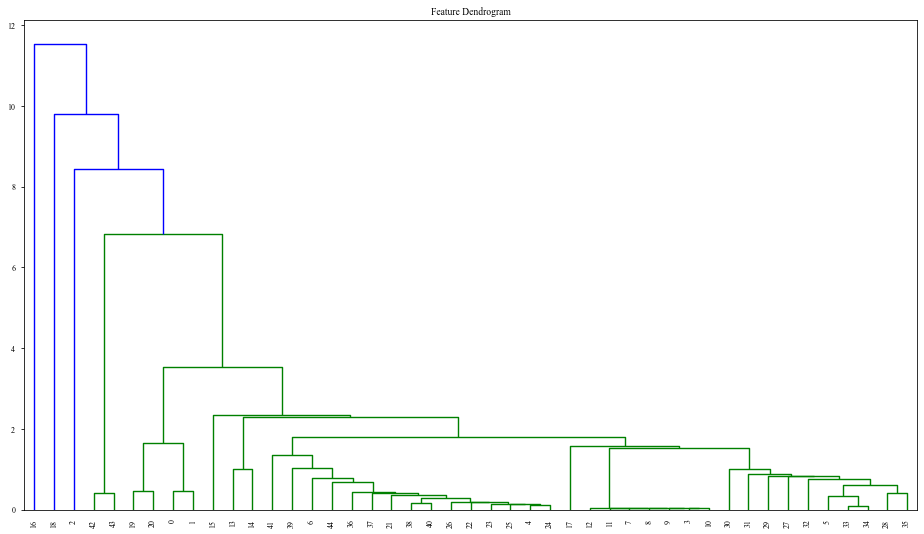

In [50]:
# plot dendogram using scipy hierarchical clustering to identify optimal
# number of clusters
plt.figure(figsize=(16,9))
plt.title("Feature Dendrogram")
dend = sch.dendrogram(sch.linkage(distArray, method='single'))

Note that we choose the 'Average' linkage method because it is the most suitable for weird-shaped datasets like ours, since we aren't using Euclidean distance but rather another arbitrary metric.

From this graph, we can draw a horizontal line right around 75 that gives us the longest distance of a vertical line before reaching a horizontal line (i.e. a linkage). At this point, we an clearly identify that there are 3 main clusters. Thus, we pick `n_clusters = 3` in our `AgglomerativeClustering` algorithm.

In [51]:
# instantiate agg clusterer with 'precomputed' affinity
agg = AgglomerativeClustering(n_clusters=3, 
                              affinity='precomputed',
                              linkage='single')

# cluster
clusters_3 = agg.fit_predict(r_corr_matrix)

In [52]:
############################################################################################
# The following code is attributable verbatim to 
# Paul Brodersen, who published it on StackOverflow
# on April 21, 2017, at:
# https://stackoverflow.com/questions/43541376/how-to-draw-communities-with-networkx

def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3., seed=40)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

############################################################################################

In [53]:
# check that feature and node order are the same
assert (f == g for f, g in zip(features, np.array(list(G.nodes))))

In [54]:
# Function to display the basic graph

def create_neighborhood_network(G, min_corr, partition, labels):
    
    # create copy
    H = G.copy()
    
    # checks all edges and removes some based on corr_dir, and min_corr
    #for feat_1, feat_2, weight in G.edges(data=True):
    #    if abs(weight['weight']) < min_corr:
    #        H.remove_edge(feat_1, feat_2)
    
    # create list for the edges and for the weights
    edges, weights = zip(*nx.get_edge_attributes(H,'weight').items())
    
    # increase weight values to make vals more distinct 
    weights = tuple([(1 + abs(x))**2 for x in weights])
    
    # positions
    positions = community_layout(H, partition)
    
    # fig size
    plt.figure(figsize=(15,15))
    
    # draws nodes
    nx.draw_networkx_nodes(H, 
                           positions,
                           labels,
                           node_color=list(partition.values()),
                           node_size=500, 
                           alpha=0.8)
    
    # styling for labels
    nx.draw_networkx_labels(H, 
                            positions, 
                            font_size=8,
                            font_family='sans-serif')
    
    # color setting
    main_color = plt.cm.GnBu
    
    # draws the edges
    nx.draw_networkx_edges(H, 
                           positions, 
                           edgelist=edges, 
                           style='solid',
                           width=weights,
                           edge_color=weights,
                           edge_cmap=main_color,
                           edge_vmin=min(weights),
                           edge_vmax=max(weights))
    
    # displays the graph without axis
    plt.axis('off')
    
    # show
    plt.show()

In [55]:
# instantiate agg clusterer with 'precomputed' affinity
agg = AgglomerativeClustering(n_clusters=5, 
                              affinity='precomputed',
                              linkage='average')

# cluster
clusters = agg.fit_predict(r_corr_matrix)

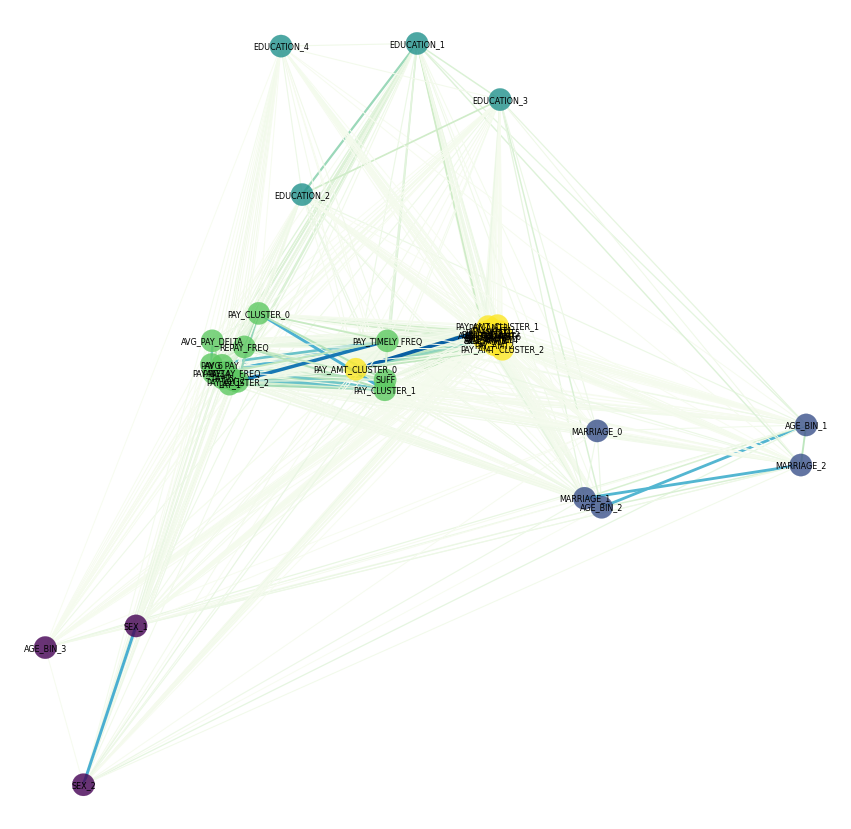

In [56]:
# create dict mapping each feature to its cluster
cluster_assignments = {}
for f, c in zip(features, clusters):
    cluster_assignments[f] = c

# plot
create_neighborhood_network(G, 0.0, cluster_assignments, features)

It is interesting to note the clusters that appear:
1. `AGE_BIN

In [57]:
# Now, we ompute the weights of each 
# feature using their within-neighborhood sum of correlations and multiplying
# them by the target variable.

# we define total corr as the summation of feature corrs within their 
# neighborhoods
total_corr = {}

# get edges of graph
edges = G.edges(data=True)

# iterate over neighborhood and sum over weights 
for feat in features:
    total_corr[feat] = 0
    for feat_i, feat_j, weight in edges:
        if feat == feat_i:
            if feat != feat_j and cluster_assignments[feat_i] == cluster_assignments[feat_j]:
                total_corr[feat] += np.abs(weight['weight'])
                
# multiply total corr for each variable by its correlation with
# the target label
total_weights = {}
for i, feat in enumerate(features):
    total_weights[feat] = total_corr[feat] * np.abs(target_corr[i])

In [58]:
# create df with both total_weights and assignment_3,
# then groupby neighborhood and sort by total_weight

# sanity check: assert same feature order
assert (k == v for k, v in zip(cluster_assignments.keys(), total_weights.keys()))
        
# create separate dfs
df_cluster_assignments = pd.DataFrame.from_dict(cluster_assignments, orient='index')
df_weights = pd.DataFrame.from_dict(total_weights, orient='index')

# join on index
df_neighborhoods = df_cluster_assignments.merge(df_weights, left_index=True, right_index=True)
df_neighborhoods.columns = ['NBRHOOD', 'WEIGHT']

# make weights absolute so that strong negative correlations are also given
# importance
df_neighborhoods['WEIGHT'] = np.abs(df_neighborhoods['WEIGHT'])

# inspect
df_neighborhoods

,NBRHOOD,WEIGHT
AGE_BIN_1,1,0.236490
AGE_BIN_2,1,0.095116
AGE_BIN_3,0,0.001939
AVG_BILL_AMT,4,0.266336
AVG_PAY,3,0.212263
AVG_PAY_AMT,4,0.169118
AVG_PAY_DELTA,3,0.041076
BILL_AMT1,4,0.062077
BILL_AMT2,4,0.039237
BILL_AMT3,4,1.038962


In [59]:
# define method for returning top n features in each neighborhood
def get_top_features(n, group_col, weight_col, df=df_neighborhoods):
    
    # sort df
    df_sorted = df.sort_values(by=[group_col, weight_col], ascending=[True, False])
    
    # get unique groups
    groups = np.unique(df_sorted[group_col])
    
    # create empty dict
    top_features_full = {}
    top_features = {}
    
    # pick top n from each group
    for g in groups:
        if g not in top_features_full.keys(): 
            top_features_full[g] = []
        if g not in top_features.keys():
            top_features[g] = []
            
        subset = df[df[group_col] == g].sort_values(weight_col, ascending=False).iloc[:n, :]
        for index, row in subset.iterrows():
            top_features_full[g].append({index: row[weight_col]})
            top_features[g].append(index)
            
    return top_features, top_features_full

In [60]:
# test
top_2, top_2_full = get_top_features(n=2, group_col='NBRHOOD', weight_col='WEIGHT')

# inspect
top_2

{0: ['SEX_1', 'AGE_BIN_3'],
 1: ['AGE_BIN_1', 'MARRIAGE_1'],
 2: ['EDUCATION_1', 'EDUCATION_2'],
 3: ['PAY_2', 'PAY_1'],
 4: ['BILL_AMT3', 'LIMIT_BAL']}

In [61]:
# helper method to get feature df
def get_df_features(df, features):
    return df[features]

In [62]:
# collapse features
top_n = top_2
best_features = []
for v in top_n.values():
    for i in v:
        best_features.append(i)

In [65]:
# get final features
df_weighted_features = get_df_features(df_train, best_features)

# inspect
df_weighted_features.describe()

,SEX_1,AGE_BIN_3,AGE_BIN_1,MARRIAGE_1,EDUCATION_1,EDUCATION_2,PAY_2,PAY_1,BILL_AMT3,LIMIT_BAL
count,36212.000000,36212.000000,36212.000000,36212.000000,36212.000000,36212.000000,36212.000000,36212.000000,3.621200e+04,36212.000000
mean,0.305065,0.006020,0.649343,0.373992,0.268419,0.402270,0.054209,0.184221,4.563325e+04,151511.263145
std,0.460441,0.077356,0.477182,0.483868,0.443143,0.490363,1.213351,1.112963,6.684730e+04,124752.366181
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.000000,-2.000000,-1.572640e+05,10000.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,2.982750e+03,50000.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.011900e+04,120000.000000
75%,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,5.774225e+04,220000.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,8.000000,1.664089e+06,1000000.000000


In [66]:
labels = df_weighted_features.columns.values
print(labels)

['SEX_1' 'AGE_BIN_3' 'AGE_BIN_1' 'MARRIAGE_1' 'EDUCATION_1' 'EDUCATION_2'
 'PAY_2' 'PAY_1' 'BILL_AMT3' 'LIMIT_BAL']


### Heuristics Approach

The Heuristics approach is motivated by the fact that the neighborhoods of features evidently carry different characteristics. Thus, there is a question: 

**Is there a specific neighborhood that by itself provides greater predictive power?**

Thus, we will proceed in a simple manner:

1. Compute the within-neighborhood sum of the features' correlations with the target variable
2. Select the highest-ranking neighborhood as the set of features

In [67]:
# form df with features, neighborhoods, and target correlations
# since they are ordered in the same way as the index
df_cluster_assignments.columns = ['NBRHOOD']
df_cluster_assignments['TGT_CORR'] = np.abs(target_corr)

# inspect
df_cluster_assignments.head()

,NBRHOOD,TGT_CORR
AGE_BIN_1,1,0.175584
AGE_BIN_2,1,0.146331
AGE_BIN_3,0,0.035699
AVG_BILL_AMT,4,0.032777
AVG_PAY,3,0.024245


In [68]:
# determine top neighborhood
df_cluster_assignments.groupby('NBRHOOD').sum().sort_values('TGT_CORR', ascending=False)

,TGT_CORR
NBRHOOD,
4,2.232128
3,1.623451
1,1.099625
2,0.597983
0,0.528862


In [69]:
# get features for top neighborhood
top_nbr = 2
top_neighborhood = []
for index, row in df_cluster_assignments[df_cluster_assignments['NBRHOOD'] == top_nbr].iterrows():
    top_neighborhood.append(index)

# examine
top_neighborhood

['EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4']

In [70]:
# get df
df_nbr_features = get_df_features(df_train, top_neighborhood)

# inspect
df_nbr_features.head()

,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


### PCA Approach

In [75]:
# select data
X = df_train[features]
y = df_train['DEFAULT']

X.shape
print('X has shape: ' + X.shape)
# standardise data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X.values), 
                        index=X.index, columns=X.columns)


In [89]:
X.columns

Index(['AGE_BIN_1', 'AGE_BIN_2', 'AGE_BIN_3', 'AVG_BILL_AMT', 'AVG_PAY',
       'AVG_PAY_AMT', 'AVG_PAY_DELTA', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'EDUCATION_1', 'EDUCATION_2',
       'EDUCATION_3', 'EDUCATION_4', 'LIMIT_BAL', 'MARRIAGE_0', 'MARRIAGE_1',
       'MARRIAGE_2', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'PAY_AMT_CLUSTER_0', 'PAY_AMT_CLUSTER_1', 'PAY_AMT_CLUSTER_2',
       'PAY_CLUSTER_0', 'PAY_CLUSTER_1', 'PAY_CLUSTER_2', 'PAY_DELAY_FREQ',
       'PAY_TIMELY_FREQ', 'REPAY_FREQ', 'SEX_1', 'SEX_2', 'SUFF'],
      dtype='object')

In [ ]:
# checking results 3 principal components
projected = PCA(n_components=3).fit_transform(X_scaled)

# plotting the training points on all 3 dimensions
fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')
ax.scatter(projected[:, 0], projected[:, 1], projected[:, 2], c=y, cmap=cm.Paired)

ax.set_xlim(-4, 10)
ax.set_ylim(-4, 10)
ax.set_zlim(-6, 4)

plt.title('Class separation with 3 Principal Components')

plt.show()

As we can see, the variance is not explained sufficiently by only 3 components out of the original XX features - significant overlapping can be observed. Therefore, we need to plot the explained variance by the number of components.



In [ ]:
# fit the PCA model
pca = PCA().fit(X_scaled)

# explained variance by number of components
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,6))
fig.suptitle('Explained Variance by Number of Components')

# plot cumulative explained variance
ax1.plot(np.cumsum(pca.explained_variance_ratio_))
ax1.set_xlabel("Number of Components")
ax1.set_ylabel("Cumulative Explained Variance")
ax1.axhline(y=.95, xmin=0, xmax=100, linewidth=1, color='r', ls='--', label='Old')
ax1.annotate('95% variance', xy=(20, 0.9), xytext=(18, 0.92))

# scree plot
ax2.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
ax2.set_xlabel("Number of Components")
ax2.set_ylabel("Explained Variance")

In [ ]:
# determine necessary components for 95% variance
cum_sum = 0
for i, r in enumerate(pca.explained_variance_ratio_):
    cum_sum += r
    if cum_sum >= 0.95:
        print('Num. Components: ', i)
        print('Explained Variance: {:.2f}%'.format(cum_sum * 100))
        break

In [ ]:
# create new PCA with 25 components and transform data
pca_25 = PCA(n_components=25)
X_pca = pca_25.fit_transform(X_scaled)

In [ ]:
# create df
df_pca_25 = pd.DataFrame(X_pca)
df_pca_25.columns = ['PC_{}'.format(i) for i in range(1,26)]

# inspect
df_pca_25.head()

## Model Selection

The Feature Engineering section has cleaned, augmented, and reduced the original dataset into **three sets of features**, each for a corresponding Feature Selection method. Each method and their corresponding DataFrame (excl. target var.) is listed below:

1. Weighted Approach: `df_weighted_features`
2. Heuristic Approach: `df_nbr_features`
3. PCA Approach: `df_pca_25`

In [ ]:
# Weighted Features
df_weighted_features.head()

In [ ]:
# Heuristic Approach
df_nbr_features.head()

In [ ]:
# PCA Approach
df_pca_25.head()

In [ ]:
# target var
df_target = df_train['DEFAULT']
df_target.head()

In [82]:
# feat eng pipeline
def feat_eng_pipeline(df):
    '''
    Returns engineered dataset.
    '''
    # create bins for 'AGE'
    # create bins for 'AGE'
    df['AGE_BIN'] = pd.cut(df['AGE'],
                              bins=[20,40,60,100],
                              labels=[1,2,3])
    # drop 'AGE'
    df.drop(['AGE'], axis=1, inplace=True)
    # Group 4,5,6,0 categories for 'EDUCATION'
    ed_map = {1:1, 2:2, 3:3, 4:4, 5:4, 6:4, 0:4}
    df.EDUCATION = df.EDUCATION.map(ed_map)
    
    # Group 0, 3 categories for 'MARRIAGE'
    marr_map = {0:0, 1:1, 2:2, 3:0}
    df.MARRIAGE = df.MARRIAGE.map(marr_map)
    # encoding categoricals
    categoricals = ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE_BIN']
    for col in categoricals: 
        df[col] = df[col].astype('category')
    # create dummy cols, join, and drop old
    cat_df = df[categoricals]
    cat_df = pd.get_dummies(cat_df)
    df = df.join(cat_df).drop(categoricals, axis=1)
    
    # define features
    pay_features = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
    pay_amt_features = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
    
    # create PAY clusters
    df_pay = df[pay_features]
    pay_clusters = _kmeans_pay[3].predict(df_pay)
    df_pay_clusters = pd.DataFrame({'PAY_CLUSTER':pay_clusters})
    df_pay_clusters['PAY_CLUSTER'] = df_pay_clusters['PAY_CLUSTER'].astype('category')
    
    # one-hot encode
    cat_df_pc = pd.get_dummies(df_pay_clusters)
    cat_df_pc.index = df.index
    df = df.join(cat_df_pc)
    
    # create PAY_AMT clusters
    df_pay_amt = df[pay_amt_features]
    pay_amt_clusters = _kmeans_pay_amt[3].predict(df_pay_amt)
    df_pay_amt_clusters = pd.DataFrame({'PAY_AMT_CLUSTER':pay_amt_clusters})
    df_pay_amt_clusters['PAY_AMT_CLUSTER'] = df_pay_amt_clusters['PAY_AMT_CLUSTER'].astype('category')
    
    # one-hot encode
    cat_df_pamtc = pd.get_dummies(df_pay_amt_clusters)
    cat_df_pamtc.index = df.index
    df = df.join(cat_df_pamtc)
    
    # average repayment status
    df['AVG_PAY'] = get_avg(df, pay_features)
    
    # 'sufficiency'
    pay_amt_features = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
    bill_features = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
    df['AVG_BILL_AMT'] = get_avg(df, bill_features)
    df['AVG_PAY_AMT'] = get_avg(df, pay_amt_features)
    df['SUFF'] = np.where(df['AVG_BILL_AMT'] <= df['AVG_PAY_AMT'], 1, 0)
     
    # average change in MoM repayment status
    dummy_train = df.copy()
    dummy_train['DELTA_12'] = dummy_train['PAY_2'] - dummy_train['PAY_1']
    dummy_train['DELTA_23'] = dummy_train['PAY_3'] - dummy_train['PAY_2']
    dummy_train['DELTA_34'] = dummy_train['PAY_4'] - dummy_train['PAY_3']
    dummy_train['DELTA_45'] = dummy_train['PAY_5'] - dummy_train['PAY_4']
    dummy_train['DELTA_56'] = dummy_train['PAY_6'] - dummy_train['PAY_5']
    deltas = ['DELTA_12', 'DELTA_23', 'DELTA_34', 'DELTA_45', 'DELTA_56']
    dummy_train['AVG_DELTA'] = dummy_train[deltas].mean(axis=1)
    df['AVG_PAY_DELTA'] = dummy_train['AVG_DELTA']
    
    # frequency variables
    for pay_feature in pay_features:
        df['FREQ_{}'.format(pay_feature)] = np.where((df[pay_feature] >= 3),1, 
                                                    (np.where(df[pay_feature] <3,0, df[pay_feature])))
    pay_delays = ['FREQ_PAY_1', 'FREQ_PAY_2','FREQ_PAY_3','FREQ_PAY_4','FREQ_PAY_5','FREQ_PAY_6',]
    df['PAY_DELAY_FREQ'] = df[pay_delays].sum(axis=1)
    for pay_feature in pay_features:
        df['TIMELY_{}'.format(pay_feature)] = np.where((df[pay_feature] <= 0),1, 
                                                    (np.where(df[pay_feature] >0,0, df[pay_feature])))
    pay_timely = ['TIMELY_PAY_1', 'TIMELY_PAY_2','TIMELY_PAY_3','TIMELY_PAY_4','TIMELY_PAY_5','TIMELY_PAY_6',]
    df['PAY_TIMELY_FREQ'] = df[pay_timely].sum(axis=1)
    df.drop(pay_delays, axis=1, inplace=True)
    df.drop(pay_timely, axis=1, inplace=True)
    pay_amounts = ['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
    for pay_amt_feature in pay_amt_features:
        df['FREQ_{}'.format(pay_amt_feature)] = np.where((df[pay_amt_feature] > 0),1, 
                                                    (np.where(df[pay_amt_feature] <=0,0,
                                                     df[pay_amt_feature])))
    repayments = ['FREQ_PAY_AMT1', 'FREQ_PAY_AMT2','FREQ_PAY_AMT3','FREQ_PAY_AMT4','FREQ_PAY_AMT5','FREQ_PAY_AMT6',]
    df['REPAY_FREQ'] = df[repayments].sum(axis=1)
    df.drop(repayments, axis=1, inplace=True)
    
    return df

In [83]:
df_test_eng = feat_eng_pipeline(df_test)

KeyError: 'AGE'

In [84]:
df_test.describe()

,LIMIT_BAL,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
count,6000.000000,6000.00000,6000.000000,6000.00000,6000.000000,6000.000000,6000.00000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6.000000e+03,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,175437.666667,-0.07100,-0.174833,-0.21200,-0.256667,-0.319333,-0.34350,53729.115667,51311.119333,49597.543500,46841.991167,41554.274667,40103.959500,6146.250833,6.344473e+03,6251.343500,5156.464167,4862.994000,5319.916667,0.211000
std,131905.841315,1.12376,1.182723,1.16674,1.178850,1.116348,1.11522,77411.882245,74290.225276,73739.999695,69041.251707,62562.774782,61111.043232,21523.044734,3.040158e+04,22638.732479,18466.518562,15310.976004,18355.191015,0.408052
min,10000.000000,-2.00000,-2.000000,-2.00000,-2.000000,-2.000000,-2.00000,-11545.000000,-67526.000000,-46127.000000,-65167.000000,-61372.000000,-209051.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,60000.000000,-1.00000,-1.000000,-1.00000,-1.000000,-1.000000,-1.00000,3213.000000,2578.500000,2487.750000,2290.750000,1900.000000,1320.000000,1000.000000,9.900000e+02,799.750000,326.000000,278.750000,288.750000,0.000000
50%,150000.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,22820.000000,20814.500000,20360.500000,19657.000000,18071.500000,17203.500000,2195.500000,2.230000e+03,2000.000000,1634.500000,1590.000000,1697.000000,0.000000
75%,250000.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,71456.500000,68612.250000,65252.750000,61357.750000,52099.000000,50620.500000,5188.750000,5.042250e+03,5000.000000,4209.500000,4145.000000,4300.000000,0.000000
max,780000.000000,8.00000,7.000000,8.00000,7.000000,7.000000,7.00000,746814.000000,671563.000000,855086.000000,706864.000000,587067.000000,514975.000000,873552.000000,1.227082e+06,889043.000000,621000.000000,426529.000000,443001.000000,1.000000


In [80]:
# engineer test df
df_test_eng = feat_eng_pipeline(df_test)

# inspect
df_test_eng.head()

KeyError: 'AGE'

In [81]:
df_test_eng.describe()

,LIMIT_BAL,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,...,PAY_AMT_CLUSTER_1,PAY_AMT_CLUSTER_2,AVG_PAY,AVG_BILL_AMT,AVG_PAY_AMT,SUFF,AVG_PAY_DELTA,PAY_DELAY_FREQ,PAY_TIMELY_FREQ,REPAY_FREQ
count,6000.000000,6000.00000,6000.000000,6000.00000,6000.000000,6000.000000,6000.00000,6000.000000,6000.000000,6000.000000,...,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,175437.666667,-0.07100,-0.174833,-0.21200,-0.256667,-0.319333,-0.34350,53729.115667,51311.119333,49597.543500,...,0.055000,0.006000,-0.229556,47189.667306,5680.240306,0.165833,-0.054500,0.071333,5.238833,4.840167
std,131905.841315,1.12376,1.182723,1.16674,1.178850,1.116348,1.11522,77411.882245,74290.225276,73739.999695,...,0.227999,0.077233,0.974118,66078.543873,13350.717368,0.371962,0.223409,0.447897,1.481944,1.697380
min,10000.000000,-2.00000,-2.000000,-2.00000,-2.000000,-2.000000,-2.00000,-11545.000000,-67526.000000,-46127.000000,...,0.000000,0.000000,-2.000000,-43253.833333,0.000000,0.000000,-1.200000,0.000000,0.000000,0.000000
25%,60000.000000,-1.00000,-1.000000,-1.00000,-1.000000,-1.000000,-1.00000,3213.000000,2578.500000,2487.750000,...,0.000000,0.000000,-0.833333,4666.333333,1200.000000,0.000000,-0.200000,0.000000,5.000000,4.000000
50%,150000.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,22820.000000,20814.500000,20360.500000,...,0.000000,0.000000,0.000000,21832.583333,2629.416667,0.000000,0.000000,0.000000,6.000000,6.000000
75%,250000.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,71456.500000,68612.250000,65252.750000,...,0.000000,0.000000,0.000000,61432.291667,5850.083333,0.000000,0.000000,0.000000,6.000000,6.000000
max,780000.000000,8.00000,7.000000,8.00000,7.000000,7.000000,7.00000,746814.000000,671563.000000,855086.000000,...,1.000000,1.000000,5.500000,566486.166667,627344.333333,1.000000,1.400000,6.000000,6.000000,6.000000


In [ ]:
# inspect
df_test_eng.info()